# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use model selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders
* Select the optimal model via cross-validation

The last stage of the lab uses LASSO estimation for model selection.  If you are doing this part of the lab, you should review the concepts in [LASSO demonstration](./prostate.ipynb) on the prostate cancer  dataset.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the basic packages.

In [263]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [264]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [265]:
#TODO
print(*mat_dict.keys(), sep="\n")
# print("\n".join(mat_dict.keys()))

__header__
__version__
__globals__
Publication
timeBase
spikes
time
handVel
handPos
target
startBins
targets
startBinned


We extract two variables, `spikes` and `handVel`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand velocity.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handVel` data, we take the first component which is the motion in the $x$-direction.

In [266]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [267]:
# TODO 
print(("There are {} bins(samples) of each of the {} neurons(features) "+ 
       "which attempt to predict \nthe {} hand velocities.\n").format(*X0.shape, *y0.shape))

print("This yields a {} x {} data matrix with a {} x 1 target vector.\n"
          .format(*X0.shape, *y0.shape))

nt, nneuron = X0.shape

print("So nt = {} and nneuron = {}.".format(nt, nneuron))

There are 15536 bins(samples) of each of the 196 neurons(features) which attempt to predict 
the 15536 hand velocities.

This yields a 15536 x 196 data matrix with a 15536 x 1 target vector.

So nt = 15536 and nneuron = 196.


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [268]:
# TODO
time = mat_dict['time'].squeeze()

# unnessesarily complicated way to show that timesteps are basically equal in length
tsamp_arr = time[1:nt] - time[:nt-1]
tsamp = np.mean(tsamp_arr)

SE = np.std(tsamp_arr)/np.sqrt(nt-2)

print(("min\t\tmean\t\tmax\t\tstd\t\tSE\n" + "{:.5f}\t\t" * 5)
          .format(np.min(tsamp_arr), np.mean(tsamp_arr), 
                  np.max(tsamp_arr), np.std(tsamp_arr),
                  SE))

print("\ntsamp = {0:} ± {1:.5}\n=> tsamp is basically {0:} s".format(tsamp, SE))

# get total time
ttotal = time[-1] - time[0]
print("\nttotal =", ttotal, "s")


min		mean		max		std		SE
0.04950		0.05000		0.05050		0.00007		0.00000		

tsamp = 0.05 ± 5.987e-07
=> tsamp is basically 0.05 s

ttotal = 776.75 s


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [280]:
from sklearn import preprocessing
print(np.mean(X0), np.std(X0))

n_train = int(nt/2)
n_test = nt-n_train


X0s = preprocessing.scale(X0)
y0s = preprocessing.scale(y0)


Xtr = X0s[:n_train]
ytr = y0s[:n_train] 
Xts = X0s[n_train:]
yts = y0s[n_train:]


# Xtr = X0[:n_train]
# ytr = y0[:n_train] 
# Xts = X0[n_train:]
# yts = y0[n_train:]

# print(Xtr)



print("Xtr={}\nytr={}\nXts={}\nyts={}".format(Xtr.shape, ytr.shape, Xts.shape, yts.shape))
print(np.mean(Xtr), np.std(Xtr))
print(np.mean(Xts), np.std(Xts))

0.772913207508 1.33877709675
Xtr=(7768, 196)
ytr=(7768,)
Xts=(7768, 196)
yts=(7768,)
0.0187892718386 1.00935227064
-0.0187892718386 0.985036973238


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [281]:
# import sklearn.linear_model
from sklearn import linear_model

# TODO
model = linear_model.LinearRegression()
model.fit(Xtr, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Measure and print the normalized RSS on the test data.  

In [282]:
def computeRsq(y_hat, y):
    RSS = np.sum((y_hat - y) ** 2)
    SST = np.sum((y_hat - np.mean(y)) ** 2)
    rsq = 1-(RSS/SST)
    print("RSS: {:.3} SST: {:.3} R^2: {:.3}".format(RSS, SST, rsq))
    return 1-(RSS/SST)

# TODO
y_hat_tr = model.predict(Xtr)
RSSn_tr = (np.mean((y_hat_tr - ytr)**2))/(np.std(ytr)**2)

rsq_tr = computeRsq(y_hat_tr, ytr)
print(("normalized RSStr = {:.4}\tR^2 = {:.4} => "+
       "{:.4}% of the var is explained by the model\n")
          .format(RSSn_tr, rsq_tr, 100*rsq_tr))

y_hat_ts = model.predict(Xts)
RSSn_ts = (np.mean((y_hat_ts - yts)**2))/(np.std(yts)**2)

rsq_ts = computeRsq(y_hat_ts, yts)

print(("normalized RSSts = {:.4}\tR^2 = {:.4} => "+
       "{:.4}% of the var is explained by the model\n")
          .format(RSSn_ts, rsq_ts, 100*rsq_ts))

print("\nThe model does badly on both the testing",
        "and training sets; however, it does much worse on test.")

RSS: 3.57e+03 SST: 4.05e+03 R^2: 0.118
normalized RSStr = 0.4688	R^2 = 0.1175 => 11.75% of the var is explained by the model

RSS: 1.36e+26 SST: 1.36e+26 R^2: 6.18e-14
normalized RSSts = 1.718e+22	R^2 = 6.184e-14 => 6.184e-12% of the var is explained by the model


The model does badly on both the testing and training sets; however, it does much worse on test.


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

RSS: 7.56e+03 SST: 7.62e+03 R^2: 0.0077
RSS: 7.52e+03 SST: 7.62e+03 R^2: 0.0124
RSS: 7.47e+03 SST: 7.62e+03 R^2: 0.0201
RSS: 7.5e+03 SST: 7.62e+03 R^2: 0.0152
RSS: 7.45e+03 SST: 7.62e+03 R^2: 0.0223
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000137
RSS: 7.45e+03 SST: 7.62e+03 R^2: 0.0218
RSS: 7.62e+03 SST: 7.62e+03 R^2: 3.24e-05
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000222
RSS: 7.62e+03 SST: 7.62e+03 R^2: 6.55e-06
RSS: 7.61e+03 SST: 7.62e+03 R^2: 0.000625
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000201
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000168
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.0
RSS: 7.59e+03 SST: 7.62e+03 R^2: 0.00439
RSS: 7.61e+03 SST: 7.62e+03 R^2: 0.000677
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000298
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000189
RSS: 7.62e+03 SST: 7.62e+03 R^2: 0.000334
RSS: 7.62e+03 SST: 7.62e+03 R^2: 2.2e-05
RSS: 7.59e+03 SST: 7.62e+03 R^2: 0.00399
RSS: 7.61e+03 SST: 7.62e+03 R^2: 0.000538
RSS: 7.52e+03 SST: 7.62e+03 R^2: 0.0133
RSS: 7.62e+03 SST: 7.62e+03 R^2: 6.7e-05
RSS: 7.62e+03 SS

<Container object of 3 artists>

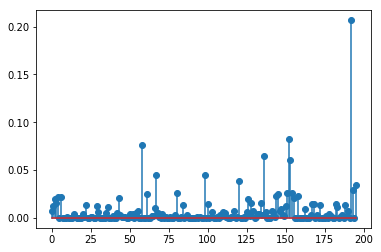

In [283]:
# TODO
# Rsq = ...
# plt.stem(...)
model = linear_model.LinearRegression()
rsq = np.zeros(Xtr.shape[1])
for i in range(Xtr.shape[1]):
    x = Xtr[:, i].reshape(-1, 1)
    model.fit(x, ytr)
    y_hat = model.predict(x)
    rsq[i] = computeRsq(ytr, y_hat)

plt.stem(rsq)

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=100` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [284]:
d = 100  # Number of neurons to use

# TODO
# Isel = ...
# print("The neurons with the ten highest R^2 values = ...)

Isel = np.argsort(-rsq)
# rsq[Isel[:d]]

print("The neurons with the ten highest R^2 values are:\n"+
            "\tidx  |  R^2\n\t"+"-"*15+"\n"+
            ("\n".join("\t{:3d}  |  {:.4f}"
            .format(*neuron) for neuron in zip(Isel[:10], rsq[Isel[:10]]))))


The neurons with the ten highest R^2 values are:
	idx  |  R^2
	---------------
	192  |  0.2067
	152  |  0.0825
	 58  |  0.0759
	136  |  0.0643
	153  |  0.0605
	 67  |  0.0451
	 98  |  0.0448
	120  |  0.0388
	195  |  0.0347
	193  |  0.0289


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [660]:
# TODO
model.fit(Xtr[:,Isel[:d]], ytr )

y_hat_tr = model.predict(Xtr[:,Isel[:d]])
y_hat_ts = model.predict(Xts[:,Isel[:d]])

print(Xtr[:,Isel[:d]].shape)
print(Xts[:,Isel[:d]].shape)


RSSper_samp_tr = np.mean((y_hat_tr - ytr) ** 2)
RSSnorm_tr = np.mean((y_hat_tr - ytr) ** 2) / (np.std(ytr)**2)

RSSper_samp_ts = np.mean((y_hat_ts - yts) ** 2)
RSSnorm_ts = np.mean((y_hat_ts - yts) ** 2) / (np.std(yts)**2)


rsq_tr = computeRsq(y_hat_tr, ytr)
rsq_ts = computeRsq(y_hat_ts, yts)



print("TRAIN: R^2={:.4}, RSSper_samp={:.4}, RSSnorm={:.4}"
          .format(rsq_tr, RSSper_samp_tr, RSSnorm_tr))

print("TEST:  R^2={:.4}, RSSper_samp={:.4}, RSSnorm={:.4}"
          .format(rsq_ts, RSSper_samp_ts, RSSnorm_ts))

(7768, 190)
(7768, 190)
RSS: 11.1 SST: 12.6 R^2: 0.118
RSS: 7.47e+03 SST: 13.5 R^2: -5.51e+02
TRAIN: R^2=0.1176, RSSper_samp=0.00143, RSSnorm=0.4688
TEST:  R^2=-551.0, RSSper_samp=0.9614, RSSnorm=0.9434


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

(-6, 6)

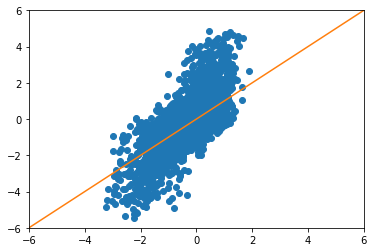

In [297]:
# TODO

plt.plot(y_hat_ts, yts, 'o')
# left_down, right_up = -4, 4
limits = [-6, 6]
plt.plot(limits, limits)
axes = plt.gca()
axes.set_xlim(limits)
axes.set_ylim(limits)

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=100`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [662]:
import sklearn.model_selection 


# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

# TODO.  
model  = linear_model.LinearRegression()

# Loop over the folds
RSSts = np.zeros((nd,nfold))
for isplit, Ind in enumerate(kf.split(Xtr)):
        
    # Get the training data in the split
    Itr, Its = Ind
    x_cv_tr = Xtr[Itr]
    y_cv_tr = ytr[Itr]
    x_cv_ts = Xtr[Its]
    y_cv_ts = ytr[Its]
    
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        
        model.fit(x_cv_tr[Isel[:d]], y_cv_tr[Isel[:d]])
        
        # Measure RSS on test data
        y_hat = model.predict(x_cv_ts)
        RSSts[it,isplit] = np.mean((y_hat-y_cv_ts)**2)
        
#     print(("{:.2f} "*19).format(*RSSts[:,isplit]))
#     print("fold#","{}:".format(isplit), ("{:.2}\t"*19).format(*RSSts[:,isplit]))
        


Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

# vars	RSS/sample	stdErr
 40	0.00285		0.000155
 30	0.00287		0.000144
 50	0.00293		0.000166
 60	0.00294		0.000155
 20	0.00306		0.000174
 10	0.00311		0.000134
 70	0.00318		0.000179
 80	0.00338		0.000209
 90	0.0037		0.000226
100	0.00423		0.000212
110	0.00494		0.000228
120	0.006		0.000276
130	0.00795		0.00051
190	0.00997		0.000506
140	0.0126		0.00128
180	0.0192		0.00216
150	0.0234		0.00293
170	0.0393		0.00284
160	0.169		0.0736


Target RSS = min(RSS)+SE = 0.002845+0.000155 = 0.003
So we need to find # vars such that the corrisponding RSS is less than 0.003

 10	0.00311	False
 20	0.00306	False
 30	0.00287	True
 40	0.00285	True
 50	0.00293	True
 60	0.00294	True
 70	0.00318	False
 80	0.00338	False
 90	0.0037	False
100	0.00423	False
110	0.00494	False
120	0.006	False
130	0.00795	False
140	0.0126	False
150	0.0234	False
160	0.169	False
170	0.0393	False
180	0.0192	False
190	0.00997	False

The model with 30 vars is the simplest model with CVRSS < targetRSS
	=> we select the model with 30 vars


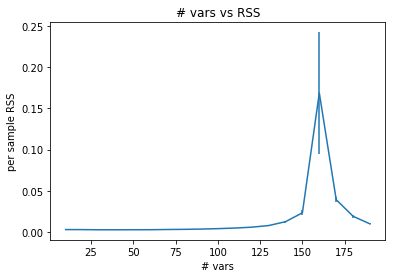

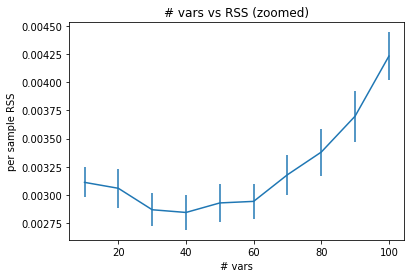

In [668]:
# TODO
# print(RSSts.shape)
means = np.mean(RSSts, axis=1)
stdErrs = np.std(RSSts, axis=1)/np.sqrt(nfold-1)
idx = np.argsort(means)
print("# vars\tRSS/sample\tstdErr")
print("\n".join(["{:3d}\t{:.3}\t\t{:.3}".format(*row) for row in zip(dtest[idx], means[idx], stdErrs[idx])]))

targetRSS = means[idx][0]+stdErrs[idx][0]
print("\n\nTarget RSS = min(RSS)+SE = {:.4}+{:.4} = {:.4}".format(means[idx][0], stdErrs[idx][0], targetRSS))
print("So we need to find # vars such that the corrisponding RSS is less than {:.4}\n".format(targetRSS))

print("\n".join(["{:3d}\t{:.3}\t{}".format(*row) for row in zip(dtest, means, means<targetRSS)]))

print("\nThe model with 30 vars is the simplest model with CVRSS < targetRSS\n\t=> we select the model with 30 vars")


# plt.plot(dtest, means)
# plt.plot(dtest, means, 'o')
plt.errorbar(dtest, means, yerr=stdErrs)
plt.title("# vars vs RSS")
plt.xlabel("# vars")
plt.ylabel("per sample RSS")

plt.figure()
plt.title("# vars vs RSS (zoomed)")
plt.errorbar(dtest[:10], means[:10], yerr=stdErrs[:10])
plt.xlabel("# vars")
plt.ylabel("per sample RSS")

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [521]:
# TODO
RSSmeans = np.mean(RSSts, axis=1)
stdErrs = np.std(RSSts, axis=1)/np.sqrt(nfold-1)
minidx = np.argmin(means)
target = RSSmeans[minidx]+stdErrs[minidx]
d = np.min(dtest[RSSmeans < target])
print("The optimal value of d is {}.".format(d))


The optimal value of d is 30.


In [658]:
model = linear_model.LinearRegression()
X_subset_tr = Xtr[:, Isel[:d]]
X_subset_ts = Xts[:, Isel[:d]]

model.fit(X_subset, ytr)
print(X_subset_tr.shape)

y_hat_tr = model.predict(X_subset_tr)
y_hat_ts = model.predict(X_subset_ts)

Rsq_tr = computeRsq(y_hat_tr, ytr)
Rsq_ts = computeRsq(y_hat_ts, yts)

print("Train R^2 = {}".format(Rsq_tr))
print("Test R^2 = {}".format(Rsq_ts))
# print(("{} R^2 = {}\n"*2).format(["Train", Rsq_tr, "Test", Rsq_ts]))

print("\nThe model still seems to generalize very badly.")

(7768, 30)
RSS: 13.0 SST: 10.7 R^2: -0.221
RSS: 7.53e+03 SST: 11.4 R^2: -6.61e+02
Train R^2 = -0.2205021361856836
Test R^2 = -660.5615919505536

The model still seems to generalize very badly.


## Using LASSO regression

Instead of using the above heuristic to select the variables, we can use LASSO regression.  

First use the `preprocessing.scale` method to standardize the data matrix `X0`.  Store the standardized values in `Xs`.  You do not need to standardize the response.  For this data, the `scale` routine may throw a warning that you are converting data types.  That is fine.

In [530]:
from sklearn import preprocessing

# TODO
Xs = preprocessing.scale(X0)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, use the LASSO method to fit a model.  Use cross validation to select the regularization level `alpha`.  Use `alpha` values logarithmically spaced from `1e-5` to `0.1`, and use 10 fold cross validation.  

In [568]:
# TODO
alphas = np.logspace(-5, -1)
# print(alphas)

nfolds = 10

model = linear_model.LassoCV(alphas=alphas, cv=nfolds, verbose=True)
model.fit(Xs, y0)

bestAlpha = model.alpha_
print("Optimal alpha = {}.".format(bestAlpha))


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Optimal alpha = 0.00020235896477251554.


Plot the mean test RSS and test RSS standard error with the `plt.errorbar` plot.

(50, 10)


<Container object of 3 artists>

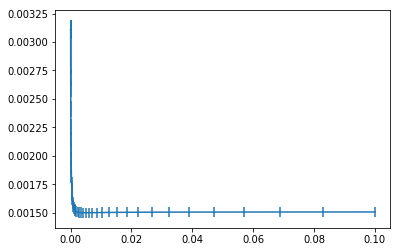

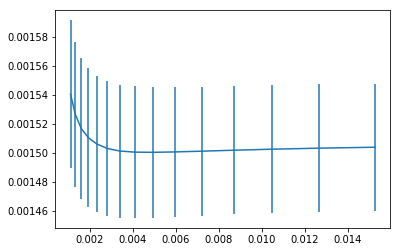

In [588]:
# TODO

mean_RSS_each_fold_and_alpha = model.mse_path_
print(mean_RSS_each_fold_and_alpha.shape)

mean_RSS_each_alpha = np.mean(mean_RSS_each_fold_and_alpha, axis=1)
std_err_each_alpha  = np.std (mean_RSS_each_fold_and_alpha, axis=1) / np.sqrt(nfolds-1)


plt.errorbar(alphas, mean_RSS_each_alpha, yerr=std_err_each_alpha)

plt.figure()
a, b = 25, 40
plt.errorbar(alphas[a:b], mean_RSS_each_alpha[a:b], yerr=std_err_each_alpha[a:b])


Find the optimal `alpha` and mean test RSS using the one standard error rule.

In [620]:
# TODO
mean_RSS_each_fold_and_alpha = model.mse_path_
mean_RSS_each_alpha = np.mean(mean_RSS_each_fold_and_alpha, axis=1)
std_err_each_alpha  = np.std (mean_RSS_each_fold_and_alpha, axis=1) / np.sqrt(nfolds-1)

# print(*["{:03.3}\t\t{:05.6f}\n".format(*row) for row in zip(alphas, mean_RSS_each_alpha)])

minidx = np.argmin(mean_RSS_each_alpha)
# print(minidx)
# print(mean_RSS_each_alpha[33])
# print(mean_RSS_each_alpha <= mean_RSS_each_alpha[33])

target = mean_RSS_each_alpha[minidx]+std_err_each_alpha[minidx]
opt_alpha_idx = np.argmax(alphas[mean_RSS_each_alpha < target])    # choose the biggest alpha => simpler model

opt_alpha = alphas[opt_alpha_idx]
opt_alpha_RSS = mean_RSS_each_alpha[opt_alpha_idx]

print("The optimal value of d is using the one standard error rule is alpha={:.5f} with RSS={:.4f}."
          .format(opt_alpha, mean_RSS_each_alpha[opt_alpha_idx]))

print("As opposed to alpha = {:.5f} with RSS={:.4f} without using the rule."
          .format(model.alpha_, mean_RSS_each_alpha[minidx]))

The optimal value of d is using the one standard error rule is alpha=0.00091 with RSS=0.0016.
As opposed to alpha = 0.00020 with RSS=0.0015 without using the rule.


Using the optimal alpha, recompute the predicted response variable on the whole data.  Plot the predicted vs. actual values.

RSS: 11.7 SST: 9.9 R^2: -0.178
R^2 Train =  -0.178255579695
RSS: 7.52e+03 SST: 10.5 R^2: -7.15e+02
R^2 Test =  -715.330852623
82


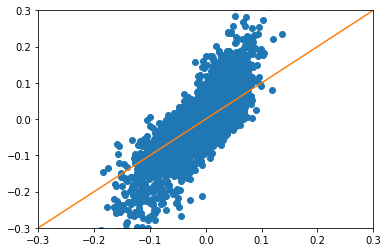

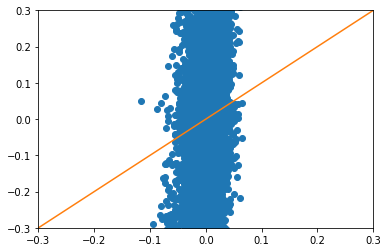

In [650]:
# TODO
new_model = linear_model.Lasso(alpha=opt_alpha)
# new_model = linear_model.Lasso(alpha=0.01)

n = len(Xs) // 2
Xtr = Xs[n:]
ytr = y0[n:]

Xtr = Xs[:n]
ytr = y0[:n]


new_model.fit(Xtr, ytr)
y_hat_tr = new_model.predict(Xtr)



limits = [-.3, .3]
plt.figure()
plt.plot(y_hat_tr, ytr, 'o')
plt.plot(limits, limits)
axes = plt.gca()
axes.set_xlim(limits)
axes.set_ylim(limits)

y_hat_ts = new_model.predict(Xts)

plt.figure()
plt.plot(y_hat_ts, yts, 'o')
plt.plot(limits, limits)
axes = plt.gca()
axes.set_xlim(limits)
axes.set_ylim(limits)

print("R^2 Train = ", computeRsq(y_hat_tr, ytr))
print("R^2 Test = ", computeRsq(y_hat_ts, yts))

print(np.sum(new_model.coef_ != 0))

## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.